## Import Required Libraries

Import the necessary libraries for satellite data processing, visualization, and analysis.

In [1]:
# Utilities
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import geopandas as gpd
import contextily as cx
import getpass
import numpy as np
from shapely.geometry import box

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubRequest,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
    parse_time,
)

from utils import plot_image

## Credentials

Credentials for Sentinel Hub services (`client_id` & `client_secret`) can be obtained in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings you can create a new OAuth Client to generate these credentials. For more detailed instructions, visit the relevant [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions you can create a profile specific to using the package for accessing Copernicus Data Space Ecosystem data collections. This is useful as changes to the the config class are usually only temporary in your notebook and by saving the configuration to your profile you won't need to generate new credentials or overwrite/change the default profile each time you rerun or write a new Jupyter Notebook. 

If you are a first time user of the Sentinel Hub Python package for Copernicus Data Space Ecosystem, you should create a profile specific to the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [ ]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
#config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
#config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
#config.save("cdse")

In [2]:
# If you have already configured a profile, uncomment and specify your profile name
config = SHConfig("cdse")

## Statistical API
In the Process API examples, we have seen how to obtain satellite imagery. Statistical API can be used in a very similar way. The main difference is that the results of Statistical API are aggregated statistical values of satellite data instead of entire images. In many use cases, such values are all that we need. By using Statistical API we can avoid downloading and processing large amounts of satellite data.

All general rules for building evalscripts apply. However, there are some specifics when using evalscripts with the Statistical API:

- The `evaluatePixel()` function must, in addition to other output, always return a `dataMask` output. This output defines which pixels are excluded from calculations. For more details and an example, see [here](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical.html).
- The default value of sampleType is `FLOAT32`.
- The output.bands parameter in the setup() function can be an array. This makes it possible to specify custom names for the output bands and different output `dataMask` for different outputs, see this [example](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical/Examples.html#multiple-outputs-with-different-datamasks-multi-band-output-with-custom-bands-names-and-different-histogram-types).

#### Define Field Boundaries

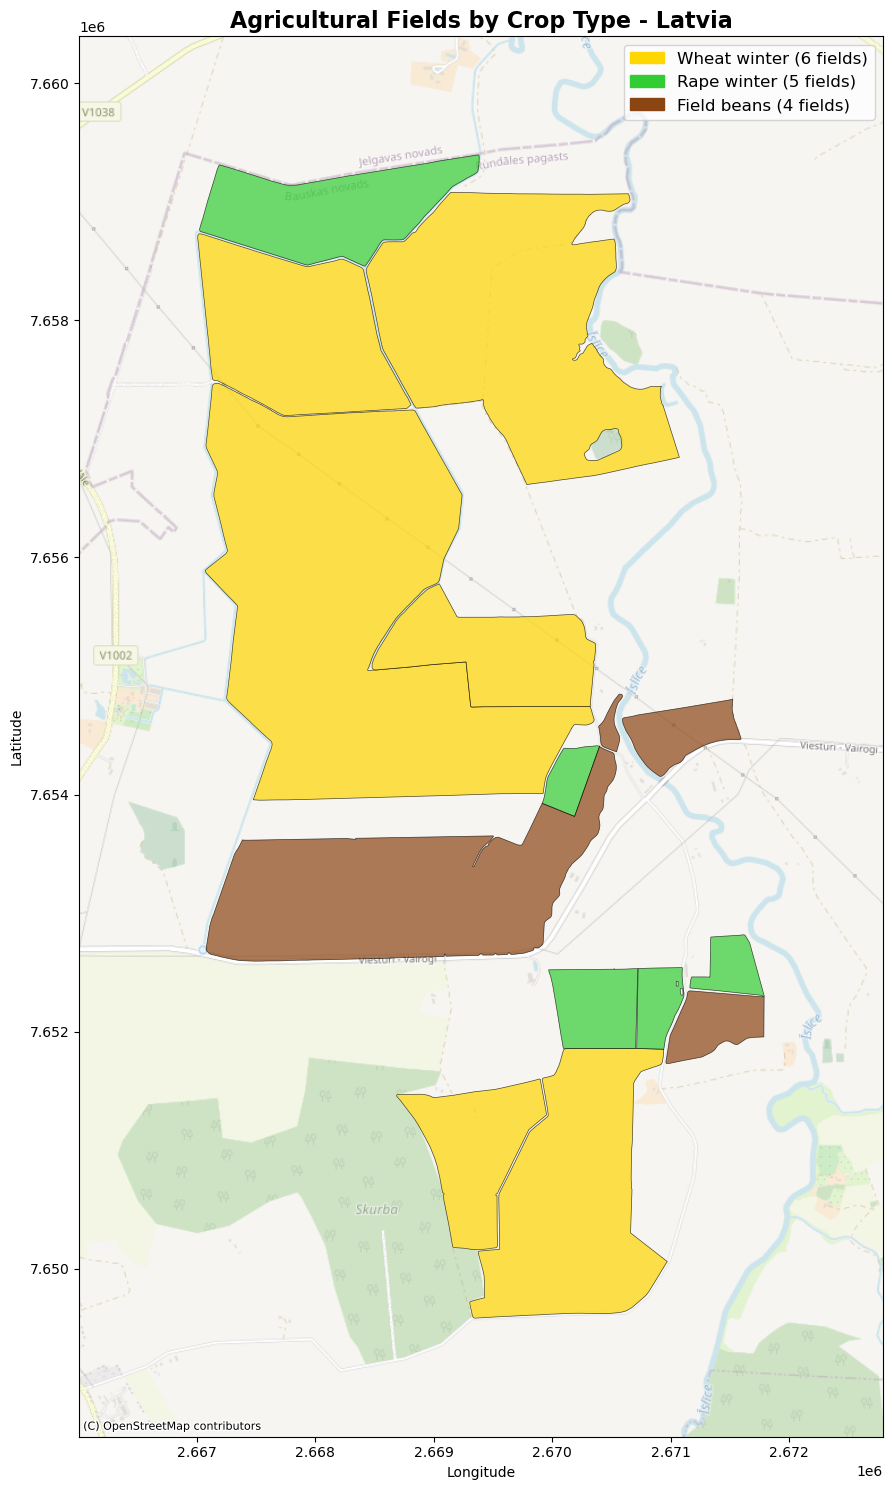

In [7]:
# Load the Latvia agricultural field boundaries with crop types
fields = "latvia_fields_wgs84.geojson"
fields_gdf = gpd.read_file(fields)

# Convert fields to Web Mercator for proper basemap alignment
fields_gdf_wm = fields_gdf.to_crs(epsg=3857)

# Create a figure to visualize the three crop types
fig, ax = plt.subplots(figsize=(15, 15))

# Define colors for each crop type
crop_colors = {
    'Wheat winter': '#FFD700',      # Gold
    'Rape winter': '#32CD32',       # Lime green  
    'Field beans': '#8B4513'        # Saddle brown
}

# Plot each crop type with different colors
legend_handles = []
for crop_type, color in crop_colors.items():
    crop_fields = fields_gdf_wm[fields_gdf_wm['crop:name_en'] == crop_type]
    if len(crop_fields) > 0:
        plot = crop_fields.plot(ax=ax, 
                        color=color, 
                        alpha=0.7, 
                        edgecolor='black', 
                        linewidth=0.5)
        # Create a manual legend entry
        import matplotlib.patches as mpatches
        patch = mpatches.Patch(color=color, label=f'{crop_type} ({len(crop_fields)} fields)')
        legend_handles.append(patch)

# Set the axis limits to the bounds of the fields (with valid bounds now)
bounds = fields_gdf_wm.total_bounds
if np.isfinite(bounds).all():
    buffer = 1000  # 1km buffer around fields
    ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
    ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

# Add basemap for context
try:
    cx.add_basemap(ax, 
                    crs=fields_gdf_wm.crs, 
                    source=cx.providers.OpenStreetMap.Mapnik,
                    alpha=0.6)
except Exception as e:
    print(f"Could not add basemap: {e}")

# Add legend manually
if legend_handles:
    ax.legend(handles=legend_handles, loc='upper right', fontsize=12)

# Set title and labels
ax.set_title('Agricultural Fields by Crop Type - Latvia', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

## Extract NDVI Time Series for Fields

Calculate NDVI statistics for each field over time using the Statistical API. This provides mean NDVI values, standard deviation, and other statistics for monitoring vegetation changes throughout the growing season.

The evalscript is configured to return both NDVI and NDWI (Normalized Difference Water Index) for comprehensive vegetation and water monitoring.

In [8]:
# define functions to extract statistics for all acquisition dates
def extract_stats(date, stat_data):
    d = {}
    for key, value in stat_data["outputs"].items():
        stats = value["bands"]["B0"]["stats"]
        if stats["sampleCount"] == stats["noDataCount"]:
            continue
        else:
            d["date"] = [date]
            for stat_name, stat_value in stats.items():
                if stat_name == "sampleCount" or stat_name == "noDataCount":
                    continue
                else:
                    d[f"{key}_{stat_name}"] = [stat_value]
    return pd.DataFrame(d)


def read_acquisitions_stats(stat_data):
    df_li = []
    for aq in stat_data:
        date = aq["interval"]["from"][:10]
        df_li.append(extract_stats(date, aq))
    return pd.concat(df_li)


def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

## 1. How to create an NDVI time series for a field of interest

### The Evalscript

In this evalscript, we are calculating NDVI. Let's remind ourselves that evalscripts operate slightly differently with Statistical API:

- The `evaluatePixel()` function must, in addition to other output, always return a `dataMask` output. This output defines which pixels are excluded from calculations. For more details and an example, see [here](https://docs.sentinel-hub.com/api/latest/api/statistical/#exclude-pixels-from-calculations-datamask-output).
- The default value of sampleType is `FLOAT32`.
- The output.bands parameter in the setup() function can be an array. This makes it possible to specify custom names for the output bands and different output `dataMask` for different outputs, see this [example](https://docs.sentinel-hub.com/api/latest/api/statistical/examples/#multiple-outputs-with-different-datamasks-multi-band-output-with-custom-bands-names-and-different-histogram-types).

In [9]:
evalscript = """
//VERSION=3
function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: [
      {
        id: "ndvi",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }]
  };
}

function evaluatePixel(samples) {
    let index = (samples.B08 - samples.B04) / (samples.B08+ samples.B04);
    return {
        ndvi: [index],
        dataMask: [samples.dataMask],
    };
}
"""

### The Request Body

Now we have defined the evalscript and the two fields of interest, we can build the first Statistical API Request, before returning the response for the first field. In this request, as part of the payload we define some input parameters:
- `time_interval` this defines the time range of our request.
- `aggregation_interval` this defines the length of time each interval is. In this case, the interval is 10 days. The aggregation intervals should be at least one day long (e.g. "P5D", "P30D"). You can only use period OR time designator not both. 

**NOTE:**
If `time_interval` is not divisible by an aggregationInterval, the last ("not full") time interval will be dismissed by default (SKIP option). The user can instead set the lastIntervalBehavior to SHORTEN (shortens the last interval so that it ends at the end of the provided time range) or EXTEND (extends the last interval over the end of the provided time range so that all the intervals are of equal duration).

In [10]:
fields_gdf = gpd.read_file(fields)

geometry = Geometry(geometry=fields_gdf.geometry.iloc[0], crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=("2023-01-01T00:00:00Z", "2023-12-31T23:59:59Z"),
        aggregation_interval="P5D",
        resolution=(0.0001, 0.0001),
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L2A.define_from(
                "s2l2a", service_url=config.sh_base_url
            ),
        ),
    ],
    geometry=geometry,
    config=config,
)

response1 = request.get_data()
# response1 # try uncommenting this line to see what the raw JSON response looks like.

### Manipulation and Visualisation of our Output

However, as it is clear to see, our response is not that useful in `json` format. It's difficult to read from a human perspective. So, let's transform it into a `pandas` dataframe. To help us achieve this, let's call some helper functions. 

In [11]:
result_df1 = read_acquisitions_stats(response1[0]["data"])
result_df1

,date,ndvi_min,ndvi_max,ndvi_mean,ndvi_stDev
0,2023-01-01,0.042672,0.103770,0.072775,0.011575
0,2023-01-06,-0.060020,0.025716,-0.013942,0.016925
0,2023-01-11,0.010893,0.051282,0.031666,0.007163
0,2023-01-16,-0.039583,0.428503,0.040366,0.075265
0,2023-01-21,-0.039857,0.056243,0.006417,0.016734
...,...,...,...,...,...
0,2023-12-02,-0.025000,0.214599,0.032938,0.039866
0,2023-12-07,-0.064383,0.019231,-0.025764,0.014667
0,2023-12-12,-0.036851,0.045142,-0.014085,0.013574
0,2023-12-17,0.167601,0.382498,0.287679,0.045281


We can take this another step further, and display the data in a time series using the Matplotlib python library:

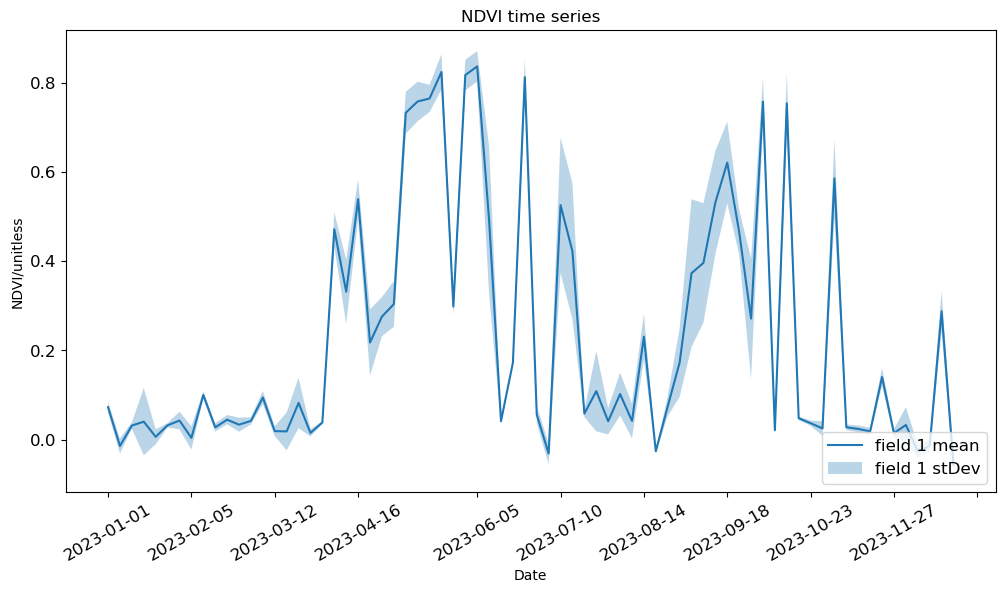

In [12]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(12, 6))

# Extract data
t1 = result_df1["date"]
ndvi_mean_field1 = result_df1["ndvi_mean"]
ndvi_std_field1 = result_df1["ndvi_stDev"]

# Plot mean and standard deviation
ax_stat.plot(t1, ndvi_mean_field1, label="field 1 mean")
ax_stat.fill_between(
    t1,
    ndvi_mean_field1 - ndvi_std_field1,
    ndvi_mean_field1 + ndvi_std_field1,
    alpha=0.3,
    label="field 1 stDev",
)

# Set tick parameters
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)

# Reduce number of x-tick labels
ax_stat.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=20))

# Set labels and title
ax_stat.set(xlabel="Date", ylabel="NDVI/unitless", title="NDVI time series")

# Set legend
ax_stat.legend(loc="lower right", prop={"size": 12});

## 2. Removing cloudy acquisitions from your NDVI time series

However, not filtering out the cloudy acquisitions means we have a very noisy time series which is not reflective of the NDVI values on the land surface. In the second example, we will filter out the cloudiest acquisitions.

### The Evalscript

This stays the same as the previous example, so we do not need to redefine it here.

### The Request Body

The request is only slightly adjusted from previously. We have added an additional argument: 

```
other_args={"dataFilter": {"maxCloudCoverage": 10}},
```
This will filter our data and means we will only use Sentinel-2 data where the cloud cover percentage of the scene was below 10%            

In [13]:
fields_gdf = gpd.read_file(fields)

geometry = Geometry(geometry=fields_gdf.geometry.iloc[0], crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=("2023-01-01T00:00:00Z", "2023-12-31T23:59:59Z"),
        aggregation_interval="P5D",
        resolution=(0.0001, 0.0001),
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L2A.define_from(
                "s2l2a", service_url=config.sh_base_url
            ),
            other_args={"dataFilter": {"maxCloudCoverage": 10}},
        ),
    ],
    geometry=geometry,
    config=config,
)

response1 = request.get_data()

### Manipulation and Visualisation of our Output

In [14]:
result_df1 = read_acquisitions_stats(response1[0]["data"])
result_df1

,date,ndvi_min,ndvi_max,ndvi_mean,ndvi_stDev
0,2023-04-01,0.340240,0.581725,0.485515,0.039341
0,2023-04-16,0.401167,0.665394,0.538889,0.044967
0,2023-04-21,0.458859,0.737461,0.599321,0.050474
0,2023-05-06,0.607709,0.841132,0.739365,0.046349
0,2023-05-11,0.594368,0.850694,0.757650,0.044330
0,2023-06-05,0.698420,0.900783,0.836275,0.034210
0,2023-06-10,0.696687,0.915987,0.852550,0.032126
0,2023-08-14,0.192298,0.828709,0.321454,0.139325
0,2023-08-19,0.118627,0.808190,0.231863,0.148778
0,2023-09-08,0.206356,0.858307,0.396074,0.133995


We can take this another step further, and display the data in a time series using the Matplotlib python library:

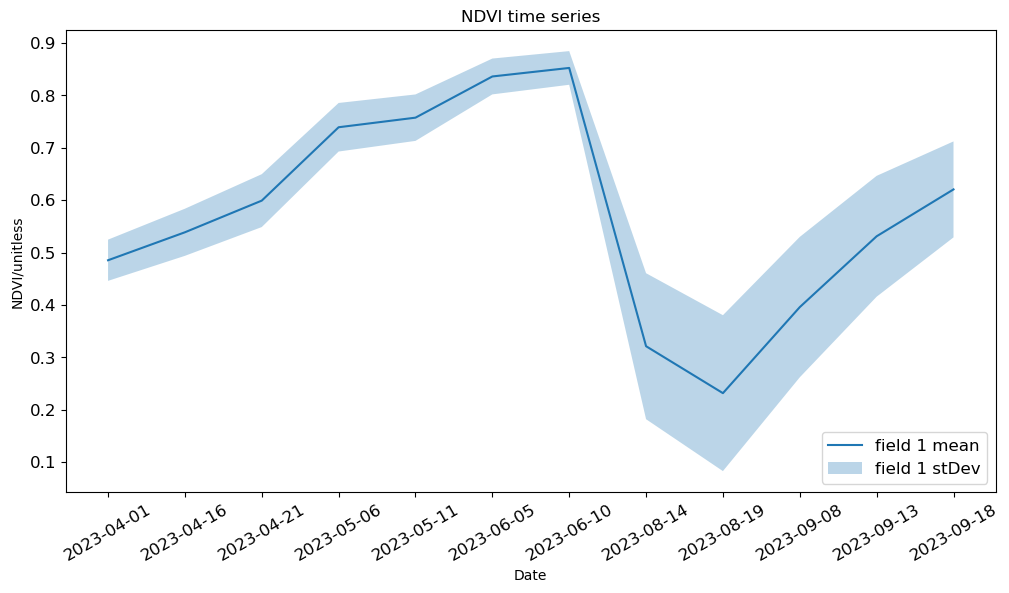

In [15]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(12, 6))

# Extract data
t1 = result_df1["date"]
ndvi_mean_field1 = result_df1["ndvi_mean"]
ndvi_std_field1 = result_df1["ndvi_stDev"]

# Plot mean and standard deviation
ax_stat.plot(t1, ndvi_mean_field1, label="field 1 mean")
ax_stat.fill_between(
    t1,
    ndvi_mean_field1 - ndvi_std_field1,
    ndvi_mean_field1 + ndvi_std_field1,
    alpha=0.3,
    label="field 1 stDev",
)

# Set tick parameters
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)

# Reduce number of x-tick labels
ax_stat.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=20))

# Set labels and title
ax_stat.set(xlabel="Date", ylabel="NDVI/unitless", title="NDVI time series")

# Set legend
ax_stat.legend(loc="lower right", prop={"size": 12});

We now have a much smoother NDVI time series. We have less data points now though. In your own time, try experimenting with the cloud coverage filter and see if you can find the sweet point between the number of data points and smoothness of the time series plot.

We can take this another step further, and display the data in a time series using the Matplotlib python library:

## 3. Outputting multiple outputs from a single statistical API request

It is also possible to define multiple outputs from your evalscript. In this example, we generate NDVI and NDWI time series in the same request and then plot them on the same plot.

### The Evalscript

In [16]:
evalscript = """
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          "B03",
          "B04",
          "B08",
          "dataMask",
        ]
      }
    ],
    output: [
      {
        id: "ndvi",
        bands: 1
      },
      {
        id: "ndwi",
        bands: 1
      },  
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}


function evaluatePixel(samples) {


    return {
      ndvi: [index(samples.B08, samples.B04)],
      ndwi: [index(samples.B08, samples.B03)],
      dataMask: [samples.dataMask]
    };
    }
"""

### The Request Body

In [17]:
fields_gdf = gpd.read_file(fields)

field1 = fields_gdf.geometry.values[0]

geometry = Geometry(geometry=field1, crs=CRS.WGS84)

request = SentinelHubStatistical(
    aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=("2022-05-01T00:00:00Z", "2023-04-30T23:59:59Z"),
        aggregation_interval="P5D",
        resolution=(0.0001, 0.0001),
    ),
    input_data=[
        SentinelHubStatistical.input_data(
            DataCollection.SENTINEL2_L2A.define_from(
                "s2l2a", service_url=config.sh_base_url
            ),
            other_args={"dataFilter": {"maxCloudCoverage": 10}},
        ),
    ],
    geometry=geometry,
    config=config,
)

response1 = request.get_data()

### Manipulation and Visualisation of our Output

In [18]:
result_df1 = read_acquisitions_stats(response1[0]["data"])
result_df1

,date,ndvi_min,ndvi_max,ndvi_mean,ndvi_stDev,ndwi_min,ndwi_max,ndwi_mean,ndwi_stDev
0,2022-05-21,0.315157,0.865490,0.427280,0.109293,0.394862,0.769591,0.474319,0.066596
0,2022-06-20,0.564846,0.905436,0.839778,0.048120,0.493960,0.800061,0.724993,0.037834
0,2022-07-20,0.544024,0.885607,0.850261,0.046299,0.545998,0.823445,0.775634,0.036063
0,2022-08-04,0.514392,0.895495,0.792085,0.047339,0.559089,0.810572,0.716708,0.039024
0,2022-08-09,0.524133,0.882638,0.725508,0.057559,0.535422,0.804643,0.669590,0.041837
0,2022-08-24,0.342105,0.847175,0.507170,0.118249,0.385666,0.772333,0.522174,0.076867
0,2022-09-08,0.370103,0.896474,0.576788,0.124026,0.468339,0.853998,0.610774,0.076680
0,2022-09-23,0.127940,0.851981,0.275474,0.173819,0.251678,0.798903,0.368738,0.121956
0,2022-10-28,0.508483,0.901493,0.729334,0.054003,0.572909,0.785104,0.658737,0.037788
0,2022-11-17,0.059321,0.402768,0.179508,0.055990,-0.016460,0.482383,0.168647,0.077890


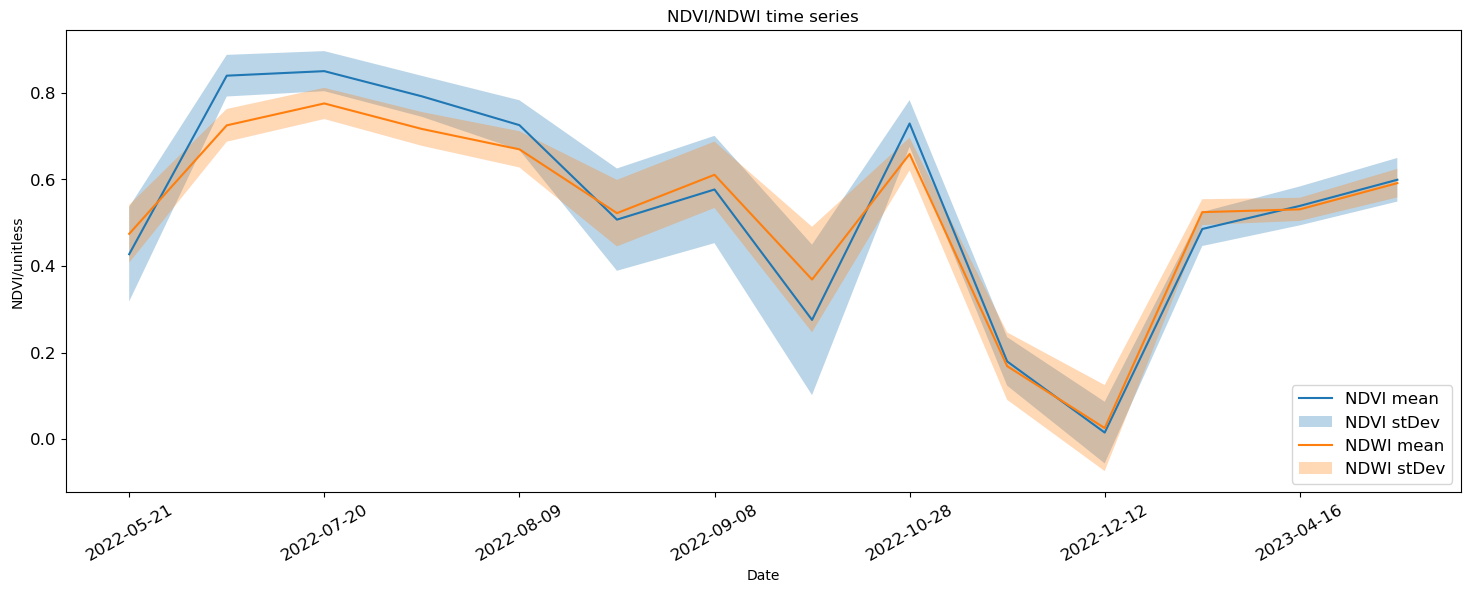

In [19]:
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(18, 6))

# Extract data
t = result_df1["date"]
ndvi_mean_field1 = result_df1["ndvi_mean"]
ndvi_std_field1 = result_df1["ndvi_stDev"]
ndwi_mean_field1 = result_df1["ndwi_mean"]
ndwi_std_field1 = result_df1["ndwi_stDev"]

# Plot NDVI mean and standard deviation
ax_stat.plot(t, ndvi_mean_field1, label="NDVI mean")
ax_stat.fill_between(
    t,
    ndvi_mean_field1 - ndvi_std_field1,
    ndvi_mean_field1 + ndvi_std_field1,
    alpha=0.3,
    label="NDVI stDev",
)

# Plot NDWI mean and standard deviation
ax_stat.plot(t, ndwi_mean_field1, label="NDWI mean")
ax_stat.fill_between(
    t,
    ndwi_mean_field1 - ndwi_std_field1,
    ndwi_mean_field1 + ndwi_std_field1,
    alpha=0.3,
    label="NDWI stDev",
)

# Set tick parameters
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)

# Reduce number of x-tick labels
ax_stat.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))

# Set labels and title
ax_stat.set(xlabel="Date", ylabel="NDVI/unitless", title="NDVI/NDWI time series")

# Set legend
ax_stat.legend(loc="lower right", prop={"size": 12})

plt.show()